In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

### Data

In [2]:
# Random seed
np.random.seed(123)

# Generate a sequence with 100 numbers
sequence_length = 100
sequence = np.zeros(sequence_length)

means = [50, 30, 60, 40]                # Define the means for the 4 segments
segment_lengths = [25, 25, 25, 25]      # Define the lengths of the segments

# Populate the sequence with segments having different means
start_index = 0
for mean, length in zip(means, segment_lengths):
    end_index = start_index + length
    sequence[start_index:end_index] = np.random.normal(loc=mean, scale=5, size=length)
    start_index = end_index

# Labels
neg_start = [5, 55]
neg_end   = [15, 65]
pos_start = [20, 70]
pos_end   = [30, 80]

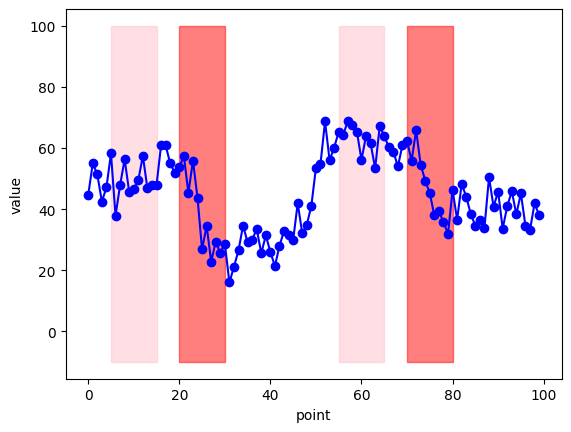

In [3]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the regions
for start, end in zip(neg_start, neg_end):
    ax.fill_betweenx((-10, 100), start, end, color='pink', alpha=0.5)

for start, end in zip(pos_start, pos_end):
    ax.fill_betweenx((-10, 100), start, end, color='red', alpha=0.5)

# Plot the sequence
ax.plot(sequence, marker = 'o', color='blue')

# Set axis labels
ax.set_xlabel('point')
ax.set_ylabel('value')

# Show the plot
plt.show()

### OPART